In [1]:
import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.inference                      import elbo as elbo_py
from mrashpen.inference                      import coordinate_descent_step as cd_step

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')


def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_convergence(objs, methods, nwarm, eps = 1e-8):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, nwarm):
        m_obj = obj[iteq:] - objmin
        m_obj = m_obj[m_obj > 0]
        ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
                 marker = 'o', markersize = 1)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def linreg_summary_df(sigma2, objs, methods):
    data     = [[strue * strue,  '-', '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.elbo_path[-1], obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'ELBO', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def linreg_summary_df_noelbo(sigma2, objs, methods):
    data     = [[strue * strue, '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

In [2]:
n = 200
p = 2000
p_causal = 50
pve = 0.95
rho = 0.0
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = rho, seed = 100)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

In [3]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)

'''
mr.ash.pen
'''
plr_lbfgs = PLR(debug = False, display_progress = False, calculate_elbo = True, maxiter = 4000)
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = None, s2init = s2init)

R[write to console]: Loading required package: Matrix



mr.ash.pen terminated at iteration 568.


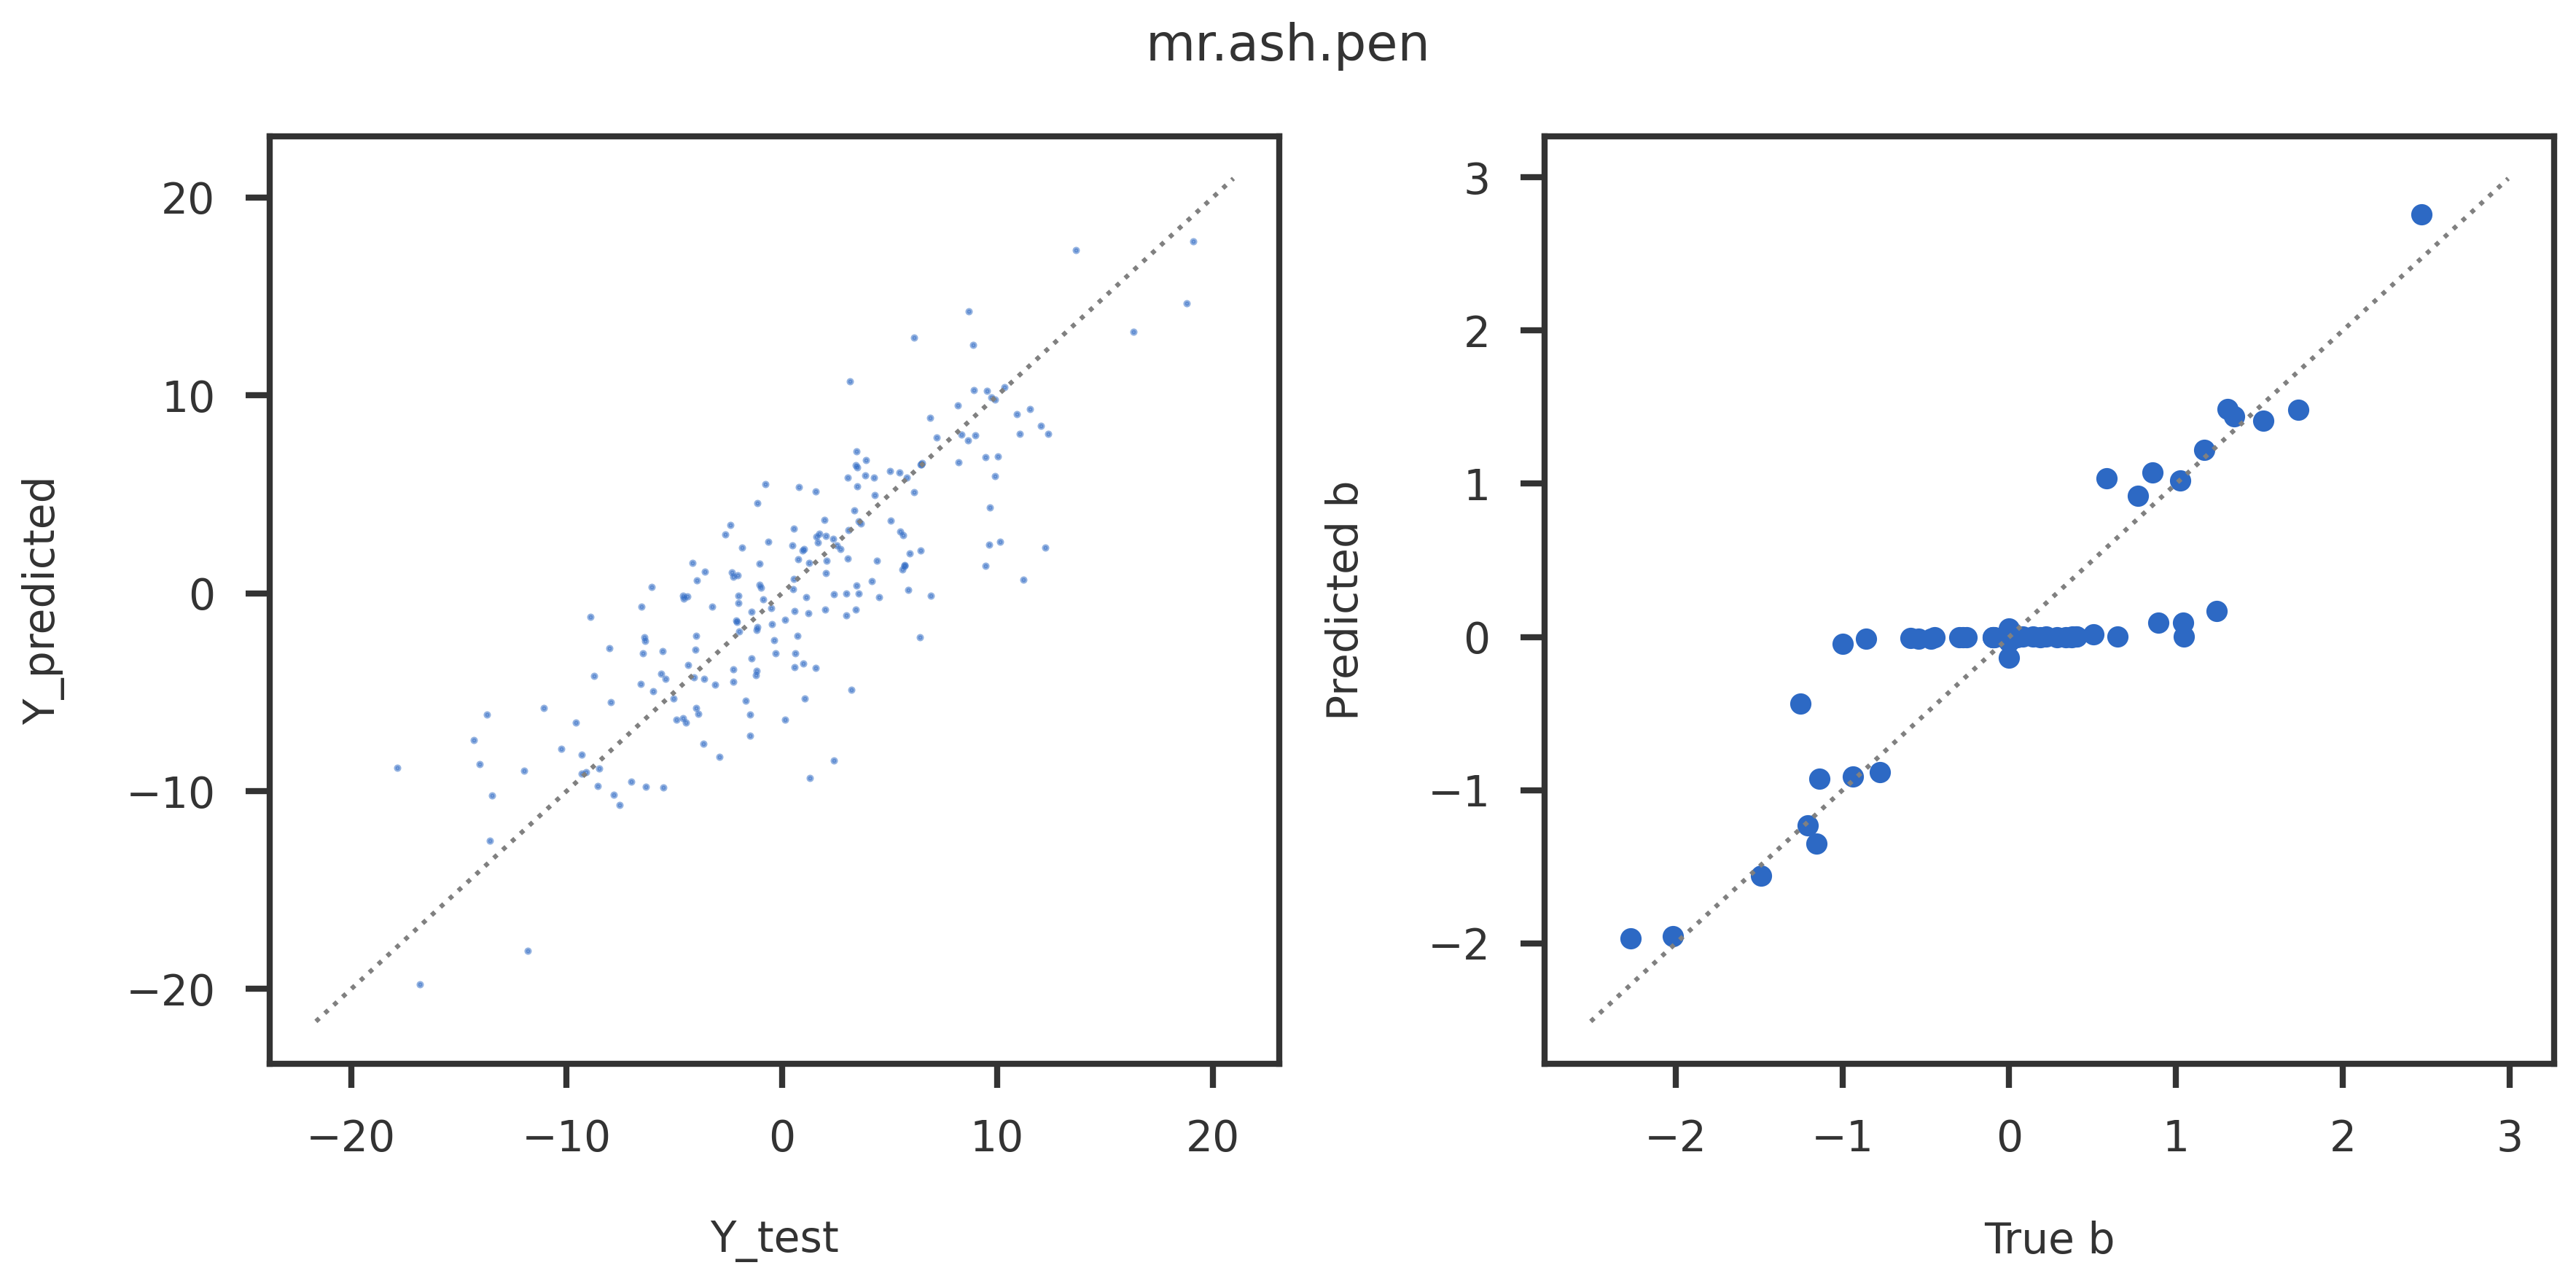

In [4]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')

In [5]:
import collections
RES_FIELDS = ['theta', 'coef', 'prior', 'residual_var', 'intercept', 'elbo_path', 'outer_elbo_path', 'obj_path', 'niter']
class ResInfo(collections.namedtuple('_ResInfo', RES_FIELDS)):
    __slots__ = ()

def ebfit(X, y, sk, wk, binit = None, s2init = 1,  
          maxiter = 1000, qb_maxiter = 100,
          calculate_elbo = True,
          epstol = 1e-8):
    n, p = X.shape
    k    = sk.shape[0]
    intercept = np.mean(y)
    y    = y - intercept
    dj   = np.sum(np.square(X), axis = 0)

    niter = 0
    w  = wk
    s2 = s2init
    b  = binit
    elbo = np.inf
    theta = np.zeros(p)
    elbo_path = list()
    obj_path  = list()
    outer_elbo_path = list()

    for it in range(maxiter):

        ### Remember old parameters
        bold  = b.copy() if b is not None else b
        wold  = w.copy()
        s2old = s2
        thetaold = theta.copy()
        elboold = elbo


        ### Update b
        plr = PLR(optimize_w = False, optimize_s = False,
                  debug = False, display_progress = False, 
                  calculate_elbo = calculate_elbo, maxiter = qb_maxiter,
                  unshrink_method = 'newton-raphson-inversion',
                  prior_optim_method = 'mixsqp',
                  call_from_em = True)
        plr.fit(X, y, sk, binit = bold, winit = wold, s2init = s2old, inv_binit = thetaold)
        b = plr.coef
        theta = plr.theta
        r = y - np.dot(X, b)
        elbo_path += plr.elbo_path
        obj_path  += plr.obj_path

        ### calculate ELBO before updating w and s2
        btilde = b + np.dot(X.T, r) / dj
        nmash = NormalMeansASHScaled(btilde, np.sqrt(s2), w, sk, d = dj, debug = False)
        phijk, mujk, varjk = nmash.posterior()
        #elbo   = elbo_py.scalemix(X, y, sk, b, w, s2,
        #                          dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
        #outer_elbo_path.append(elbo)

        ### Update w
        w = np.sum(phijk, axis = 0) / p

        ### Update s2
        bbar   = np.sum(phijk * mujk, axis = 1)
        a1     = np.sum(dj * bbar * btilde)
        varobj = np.dot(r, r) - np.dot(np.square(b), dj) + a1
        s2     = (varobj + p * (1 - w[0]) * s2old) / (n + p * (1 - w[0]))

        ### Update ELBO / new b
        b      = bbar.copy()
        elbo   = elbo_py.scalemix(X, y, sk, b, w, s2,
                                  dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
        outer_elbo_path.append(elbo)

        ### Convergence
        ### No elbo in history before one iteration so cannot compare
        if (it > 0) and (elboold - elbo < epstol):
            break
    print (f"mr.ash.pen (EM) terminated at iteration {it + 1}.")

    res = ResInfo(theta = theta,
                  coef = b,
                  prior = w,
                  residual_var = s2,
                  intercept = intercept,
                  elbo_path = elbo_path,
                  outer_elbo_path = outer_elbo_path,
                  obj_path = obj_path,
                  niter = len(obj_path))

    return res

In [6]:
'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, wk, binit = lasso_b, s2init = 1, maxiter = 400, qb_maxiter = 50)

mr.ash.pen (EM) terminated at iteration 400.


In [35]:
def ws_one_step(X, y, b, winit, s2init, sk, dj):
    n, p = X.shape
    ### calculate posterior
    r      = y - np.dot(X, b)
    btilde = b + np.dot(X.T, r) / dj
    nmash  = NormalMeansASHScaled(btilde, np.sqrt(s2init), winit, sk, d = dj, debug = False)
    phijk, mujk, varjk = nmash.posterior()

    ### Update w
    wnew   = np.sum(phijk, axis = 0) / p

    ### Update s2
    bbar   = np.sum(phijk * mujk, axis = 1)
    a1     = np.sum(dj * bbar * btilde)
    varobj = np.dot(r, r) - np.dot(np.square(b), dj) + a1
    s2new  = (varobj + p * (1 - wnew[0]) * s2init) / (n + p * (1 - wnew[0]))
    
    ### Update ELBO
    elbo   = elbo_py.scalemix(X, y, sk, bbar, wnew, s2new,
                              dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
    
    return bbar, wnew, s2new, elbo


def ebfit(X, y, sk, 
          binit = None, winit = None, s2init = None,
          maxiter = 500, qb_maxiter = 20,
          calculate_elbo = True,
          epstol = 1e-8,
          unshrink_method = 'heuristic',
          is_prior_scaled = True,
          display_progress = False,
          debug = False,
          plr_debug = False
         ):
    
    n, p = X.shape
    k    = sk.shape[0]
    intercept = np.mean(y)
    y    = y - intercept
    dj   = np.sum(np.square(X), axis = 0)

    niter = 0
    wk    = winit
    s2    = s2init
    bbar  = binit
    elbo  = np.inf
    theta = np.zeros(p)
    elbo_path       = list()
    obj_path        = list()
    outer_elbo_path = list()
    
    plr = PLR(method = 'L-BFGS-B', optimize_w = False, optimize_s = False,
          debug = debug, 
          display_progress = display_progress, 
          calculate_elbo = calculate_elbo, 
          maxiter = qb_maxiter,
          unshrink_method = unshrink_method,
          prior_optim_method = 'softmax',
          call_from_em = True)
    
    
    for itr in range(maxiter):
        '''
        New coefficients
        '''
        plr.fit(X, y, sk, binit = bbar, winit = wk, s2init = s2, inv_binit = theta)
        theta      = plr.theta
        elbo_path += plr.elbo_path
        obj_path  += plr.obj_path
        '''
        Empirical Bayes update for wk and s2, also advances coef one step
        '''
        bbar, wk, s2, elbo = ws_one_step(X, y, plr.coef, plr.prior, plr.residual_var, sk, dj)
        outer_elbo_path.append(elbo)
        '''
        Termination criteria
        '''
        if (itr > 0) and (elboold - elbo < epstol): break
        elboold = elbo.copy()

        
    res = ResInfo(theta = theta,
                  coef = bbar,
                  prior = wk,
                  residual_var = s2,
                  intercept = intercept,
                  elbo_path = elbo_path,
                  outer_elbo_path = outer_elbo_path,
                  obj_path = obj_path,
                  niter = len(obj_path))

    return res

In [36]:
'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, binit = lasso_b, winit = None, s2init = s2init, maxiter = 400, qb_maxiter = 50)

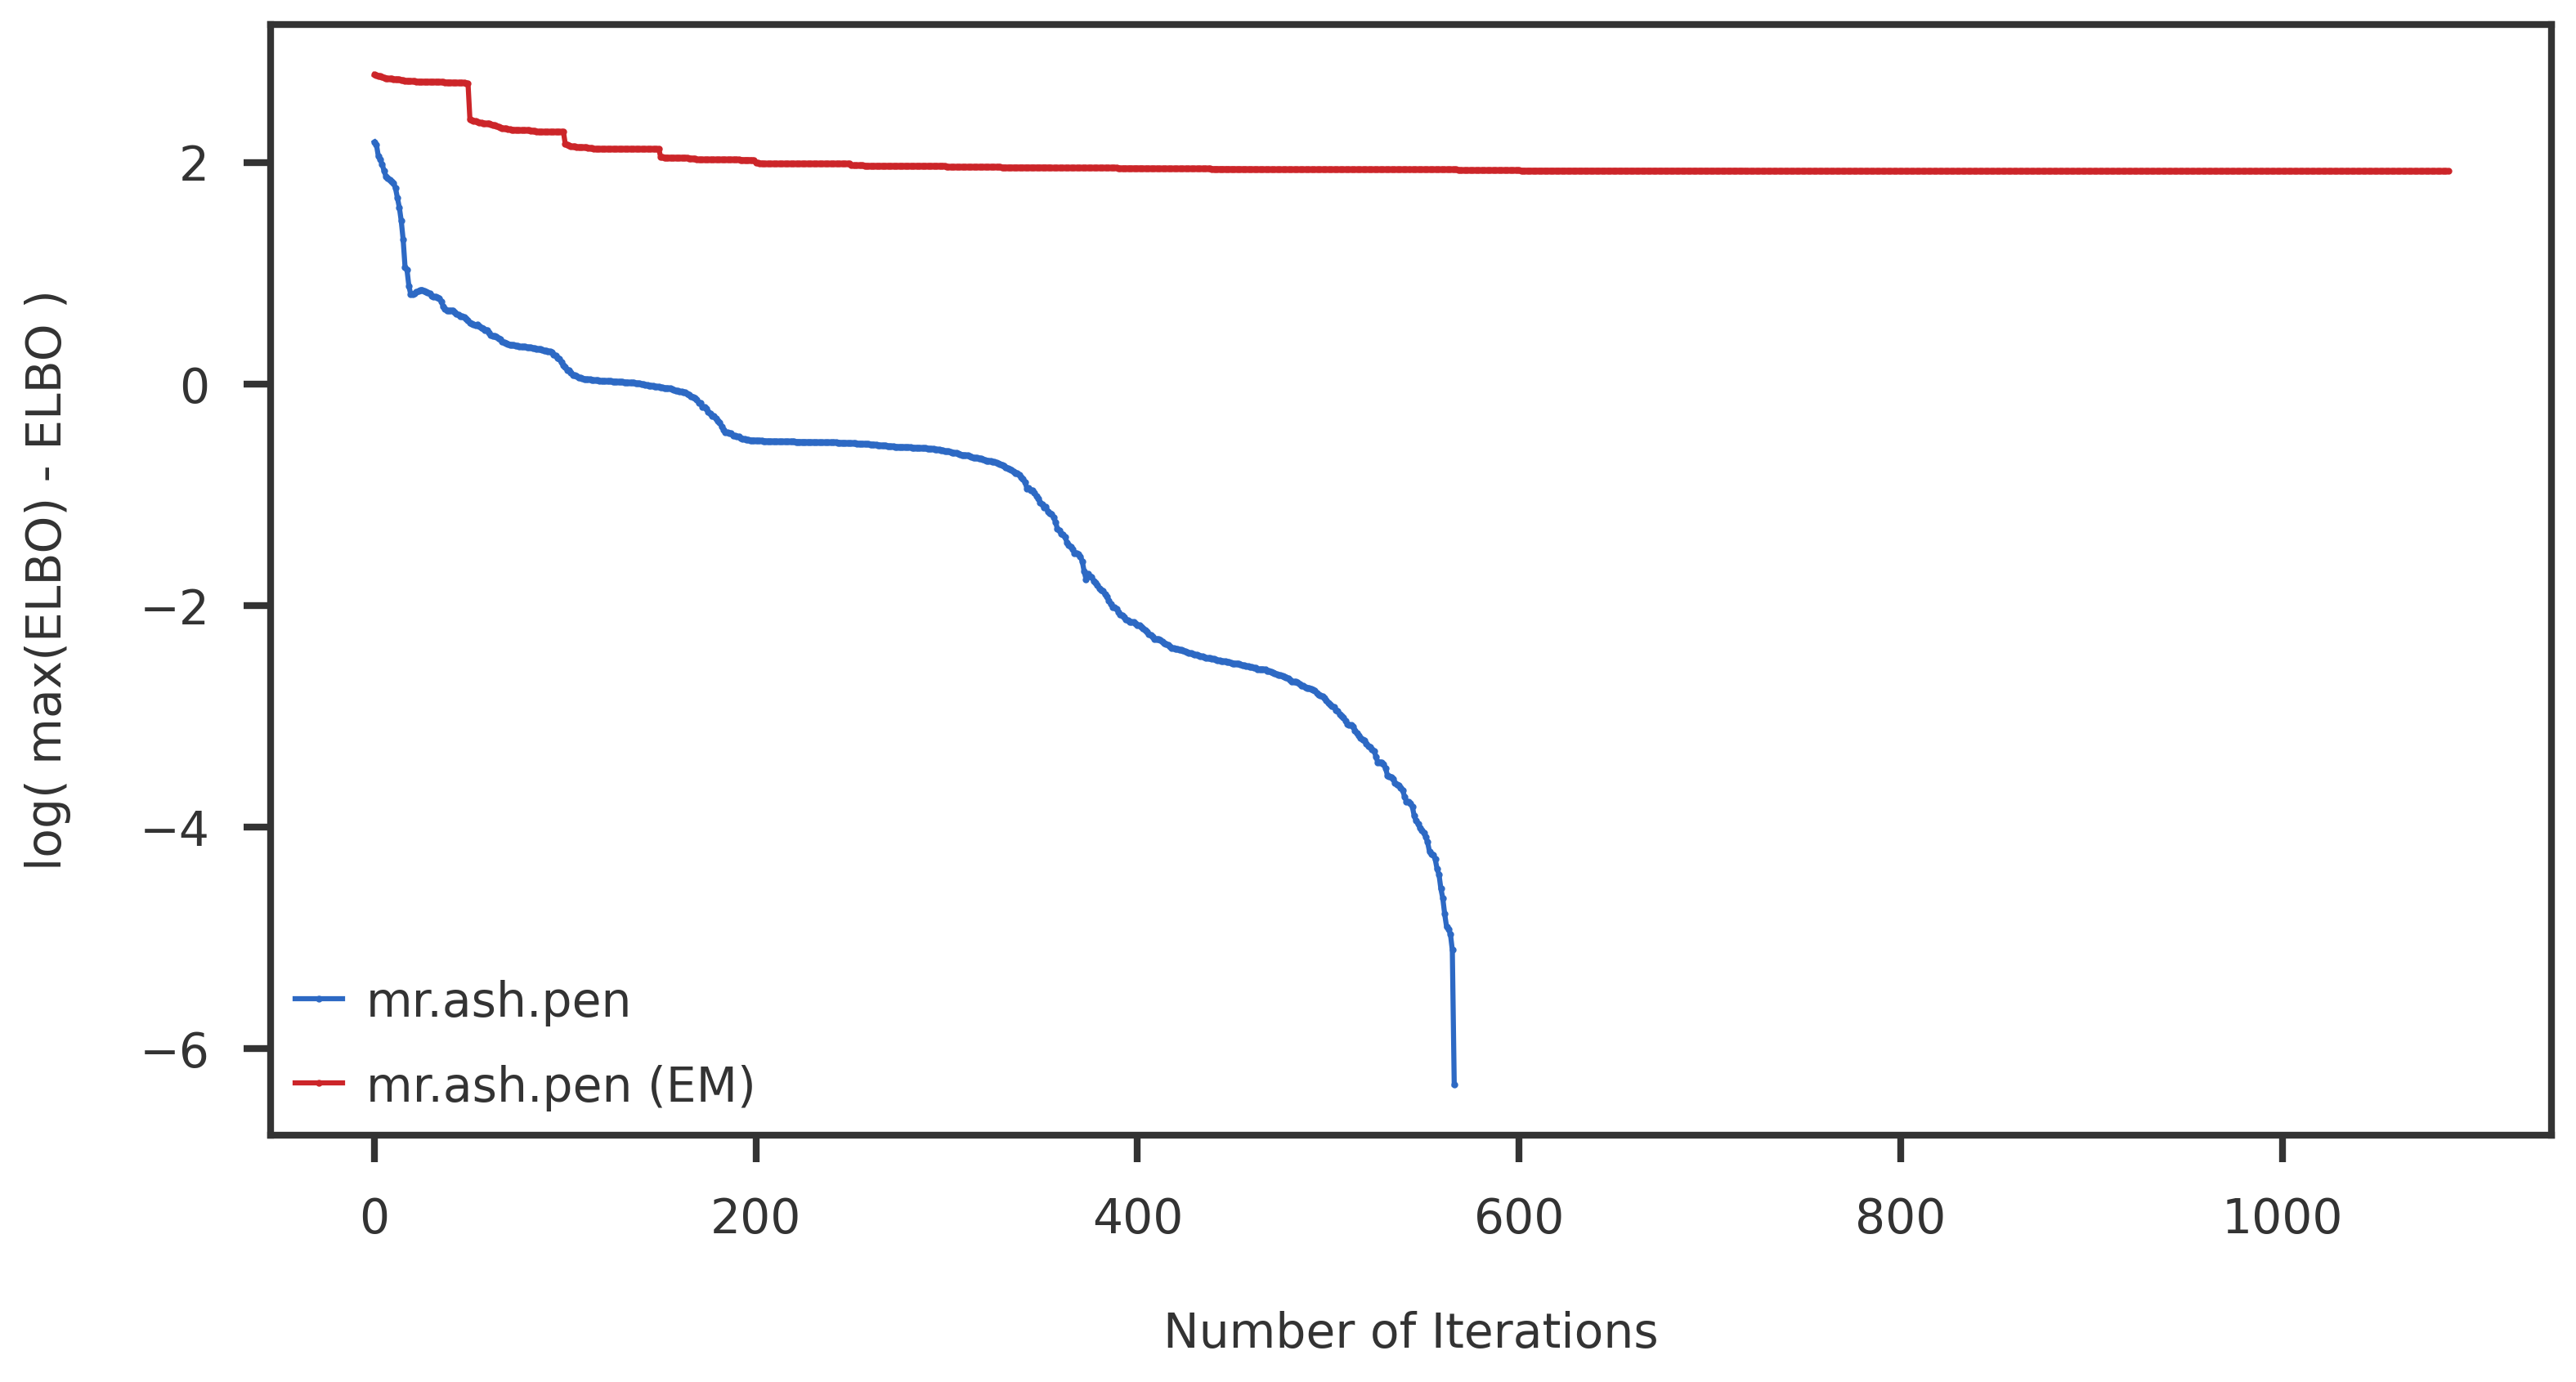

In [37]:
kinit   = [0, 0]
objs    = [plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

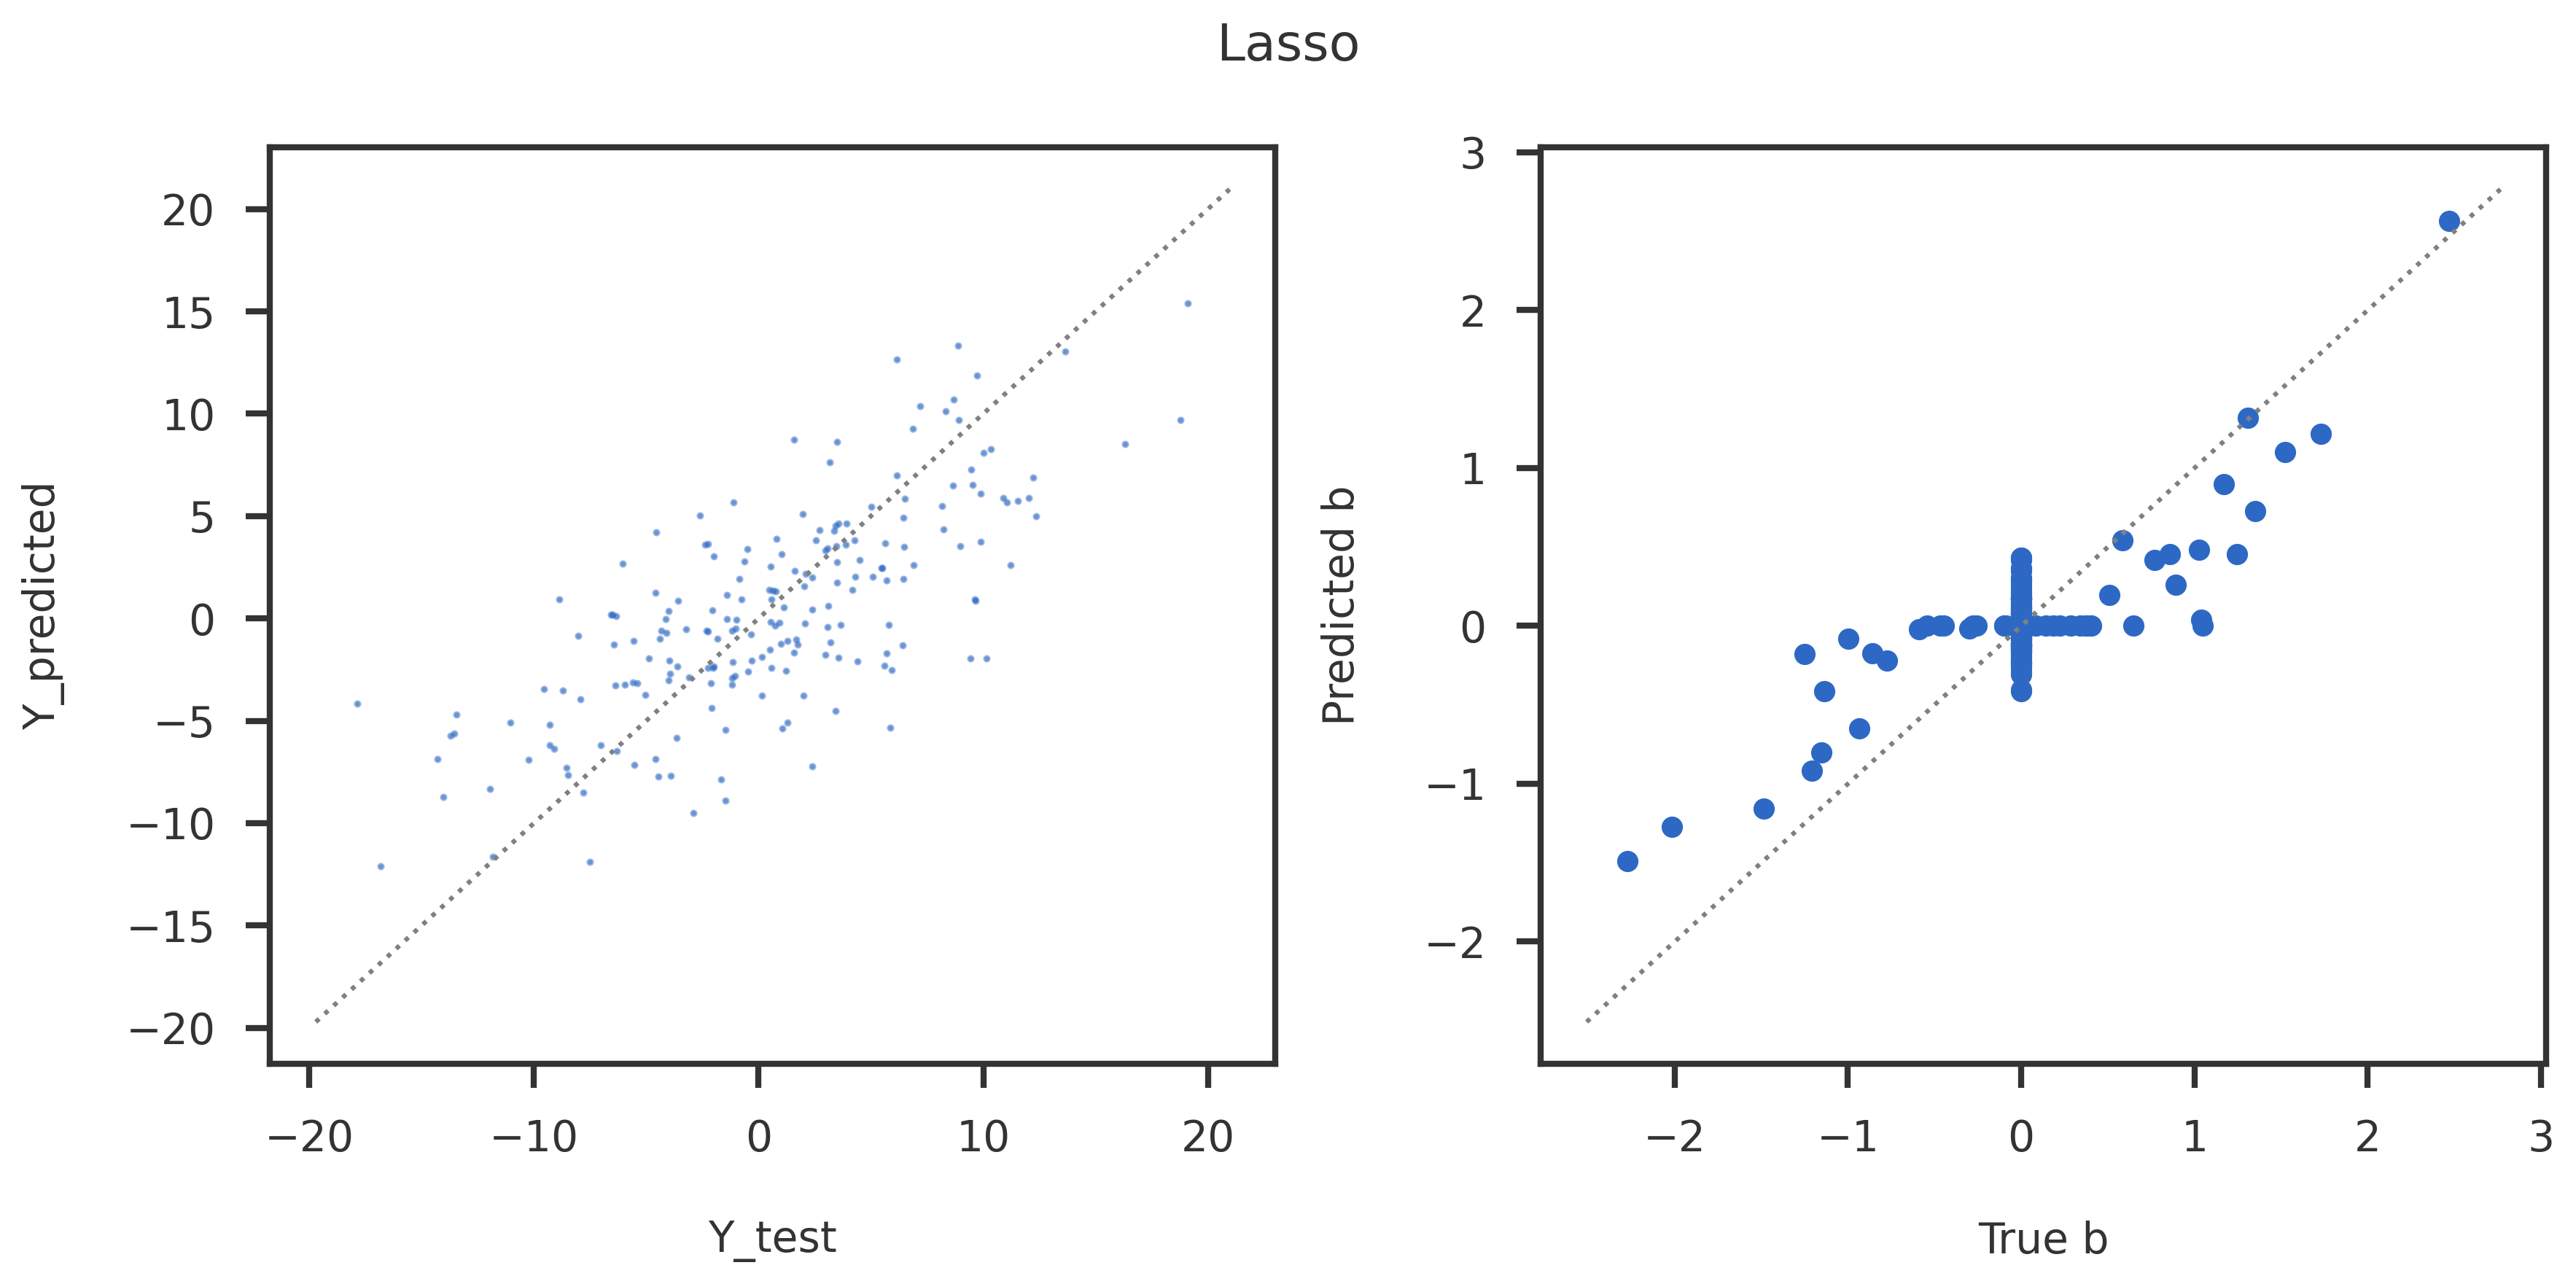

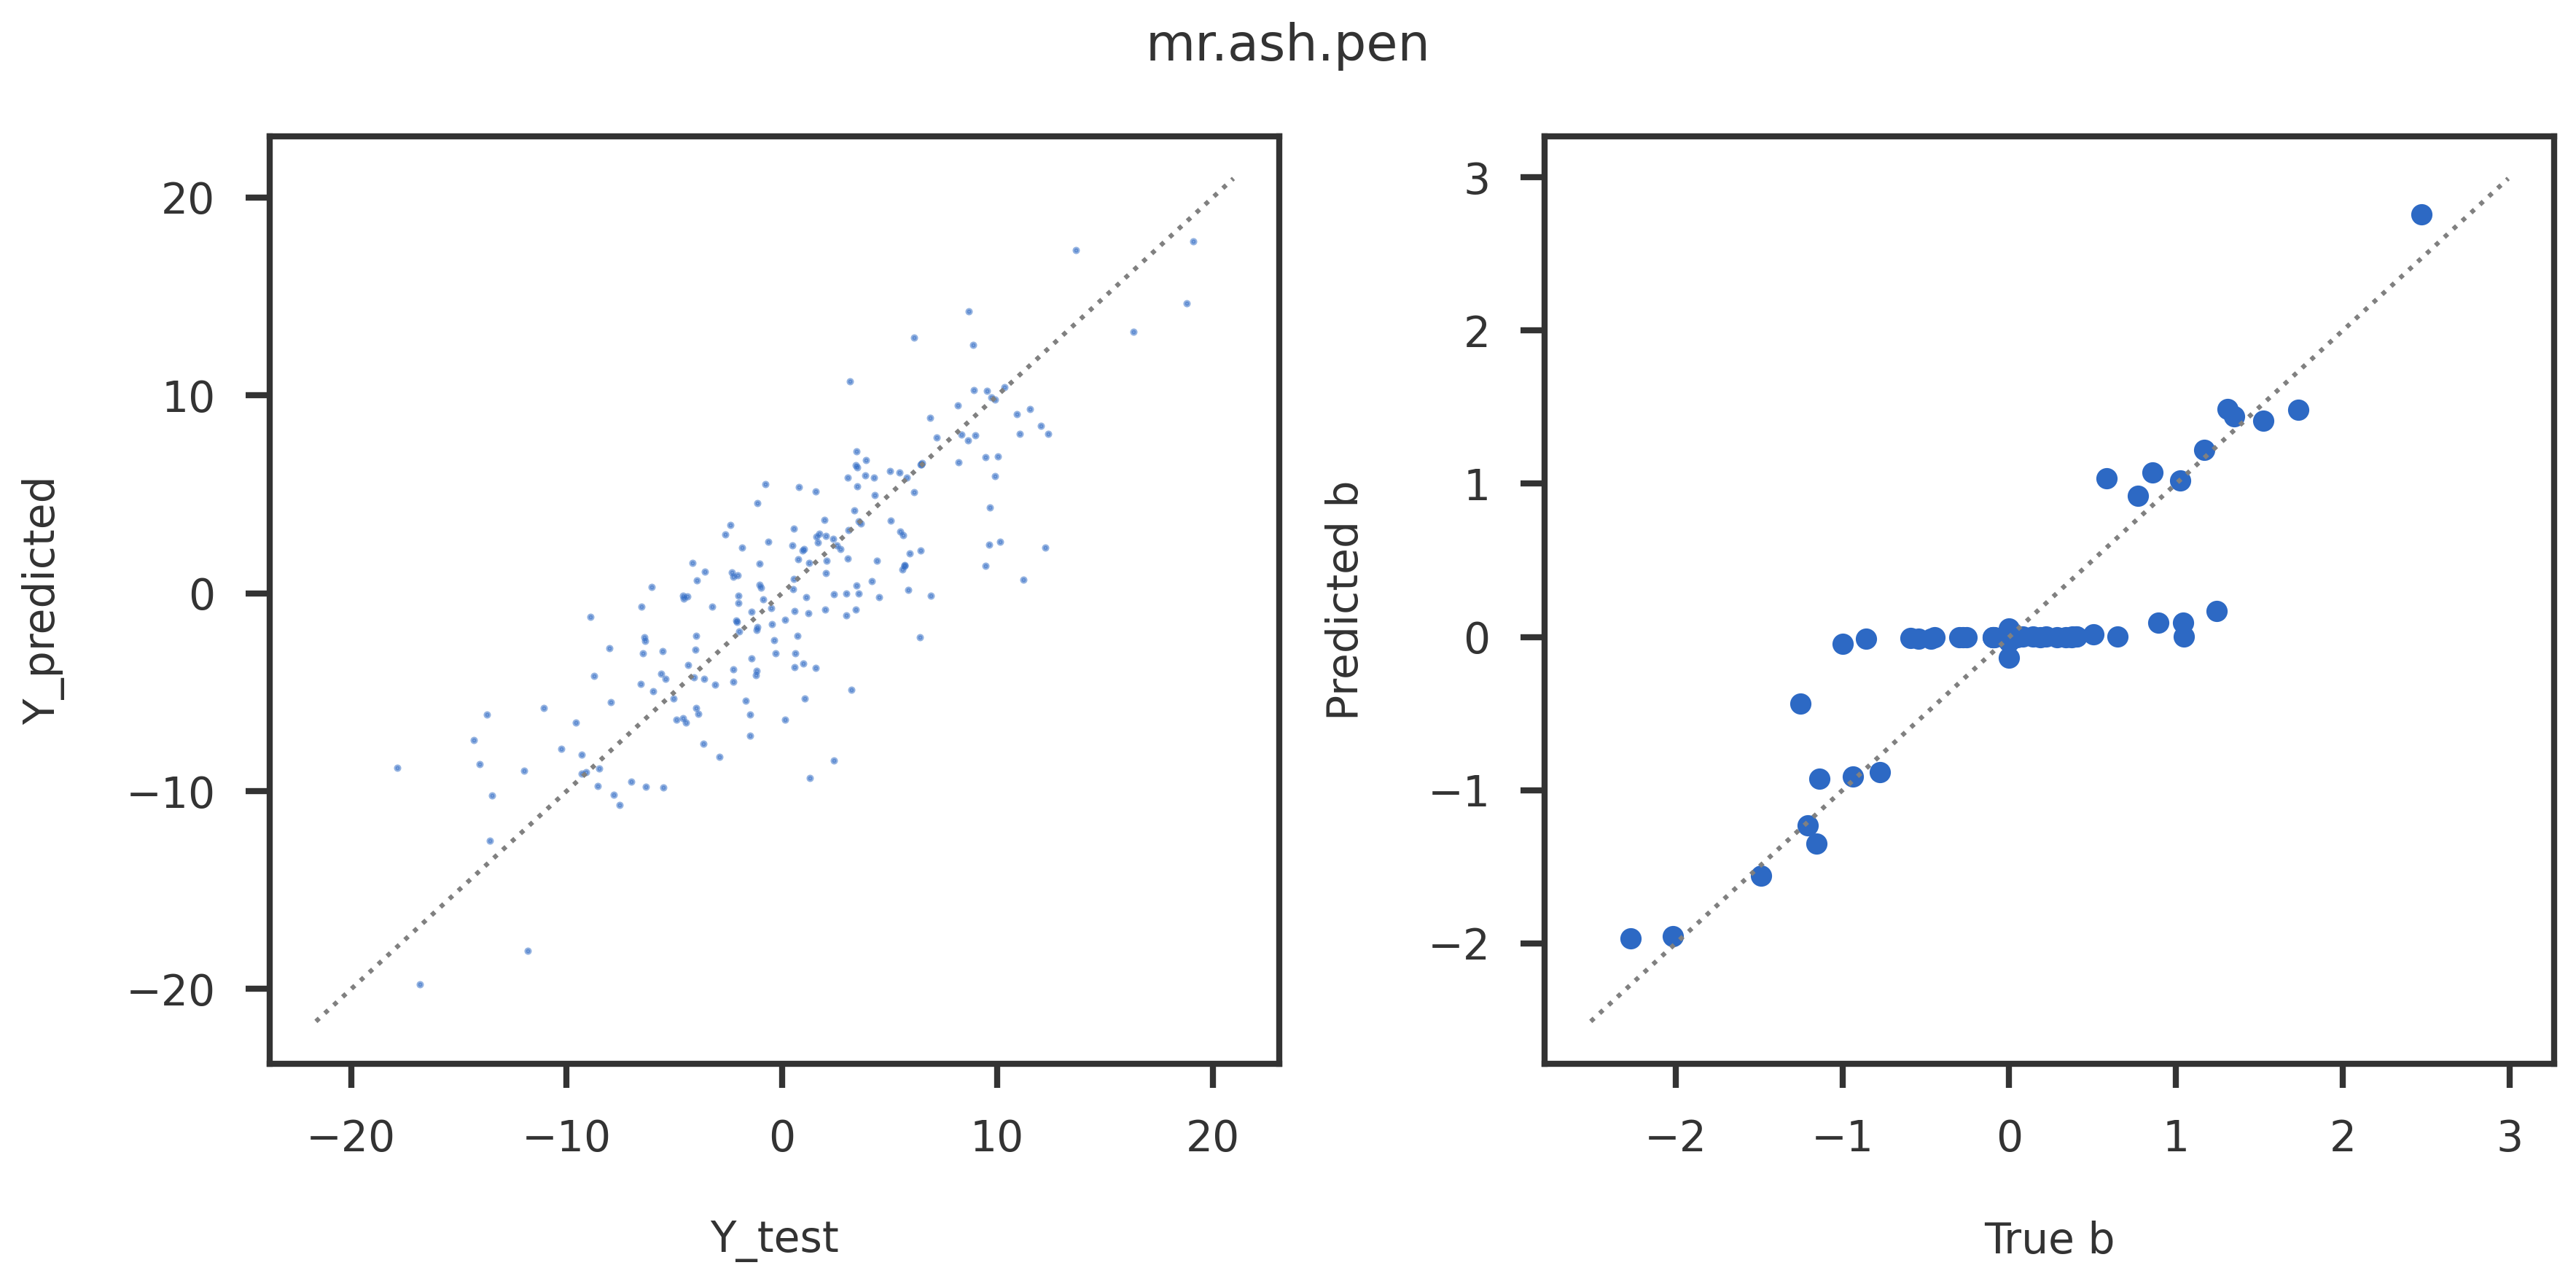

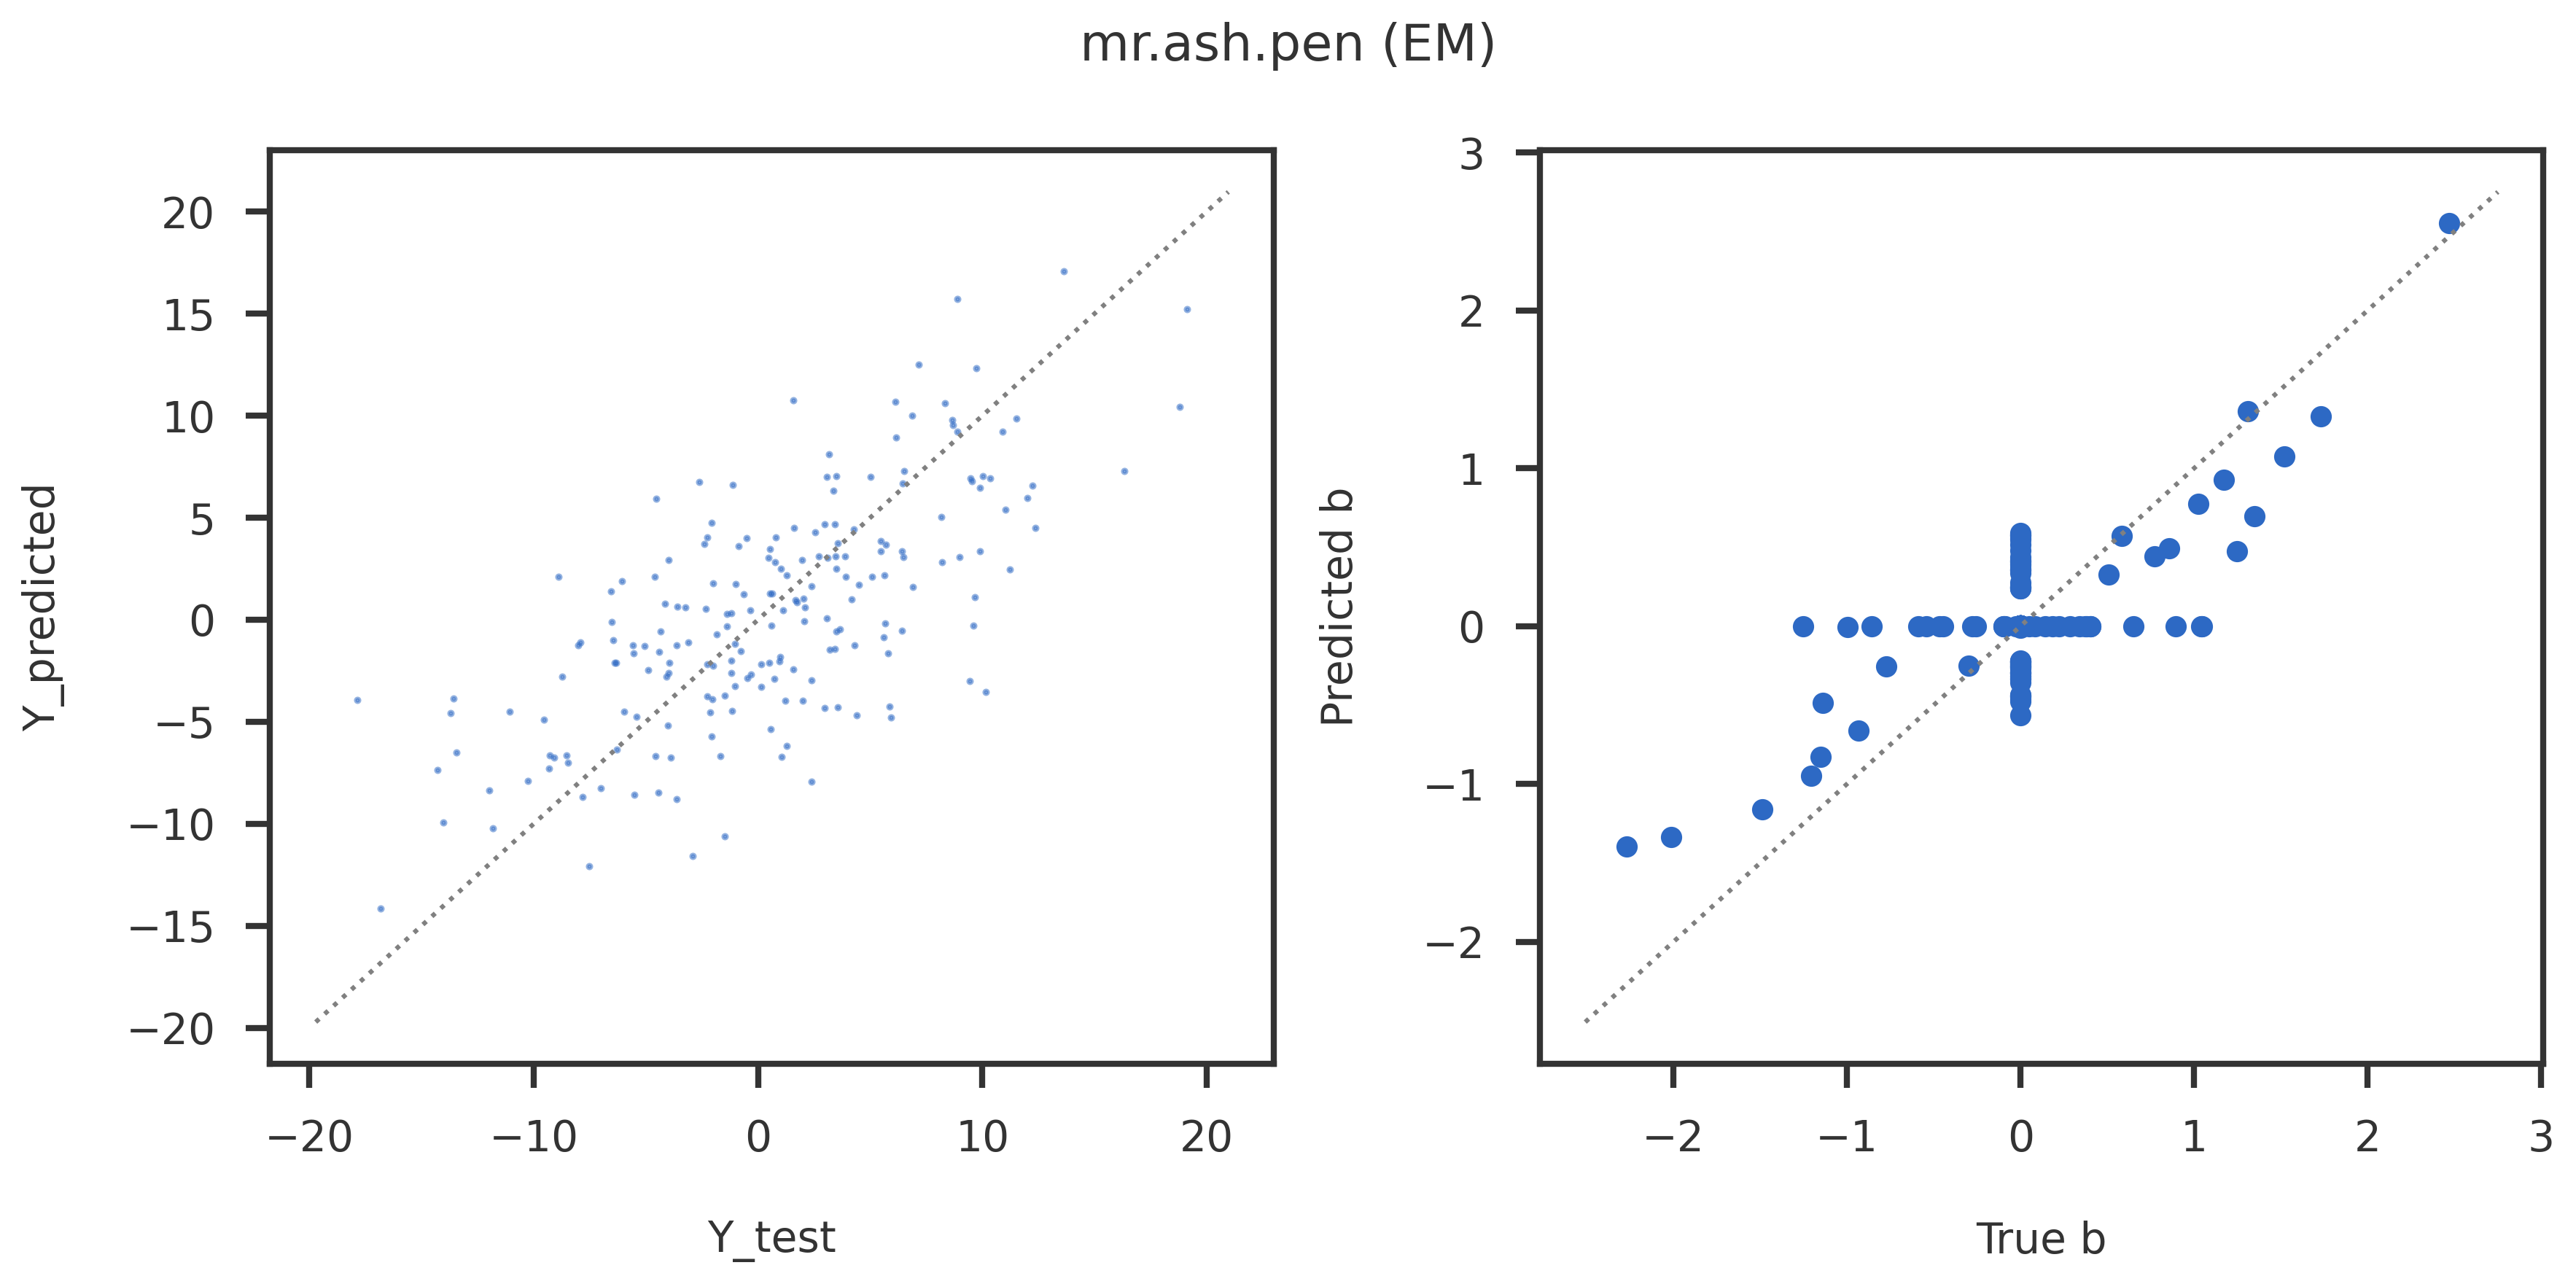

In [38]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                    plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')